## Решение соревнования

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_auc_score

In [2]:
train_data = pd.read_csv('data/train_data.csv')
train_target = pd.read_csv('data/train_target.csv', header = None, names  = ['Answ'])
test_data = pd.read_csv("data/test_data.csv", sep = ',', index_col=0)

In [3]:
train_data.shape

(27595, 20)

In [4]:
train_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,student,single,high.school,no,no,no,telephone,jun,mon,901,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1
1,46,admin.,married,university.degree,no,yes,no,cellular,aug,tue,208,2,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1
2,49,blue-collar,married,basic.4y,unknown,yes,yes,telephone,jun,tue,131,5,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1
3,31,technician,married,university.degree,no,no,no,cellular,jul,tue,404,1,999,0,nonexistent,-2.9,92.469,-33.6,1.044,5076.2
4,42,housemaid,married,university.degree,no,yes,no,telephone,nov,mon,85,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8


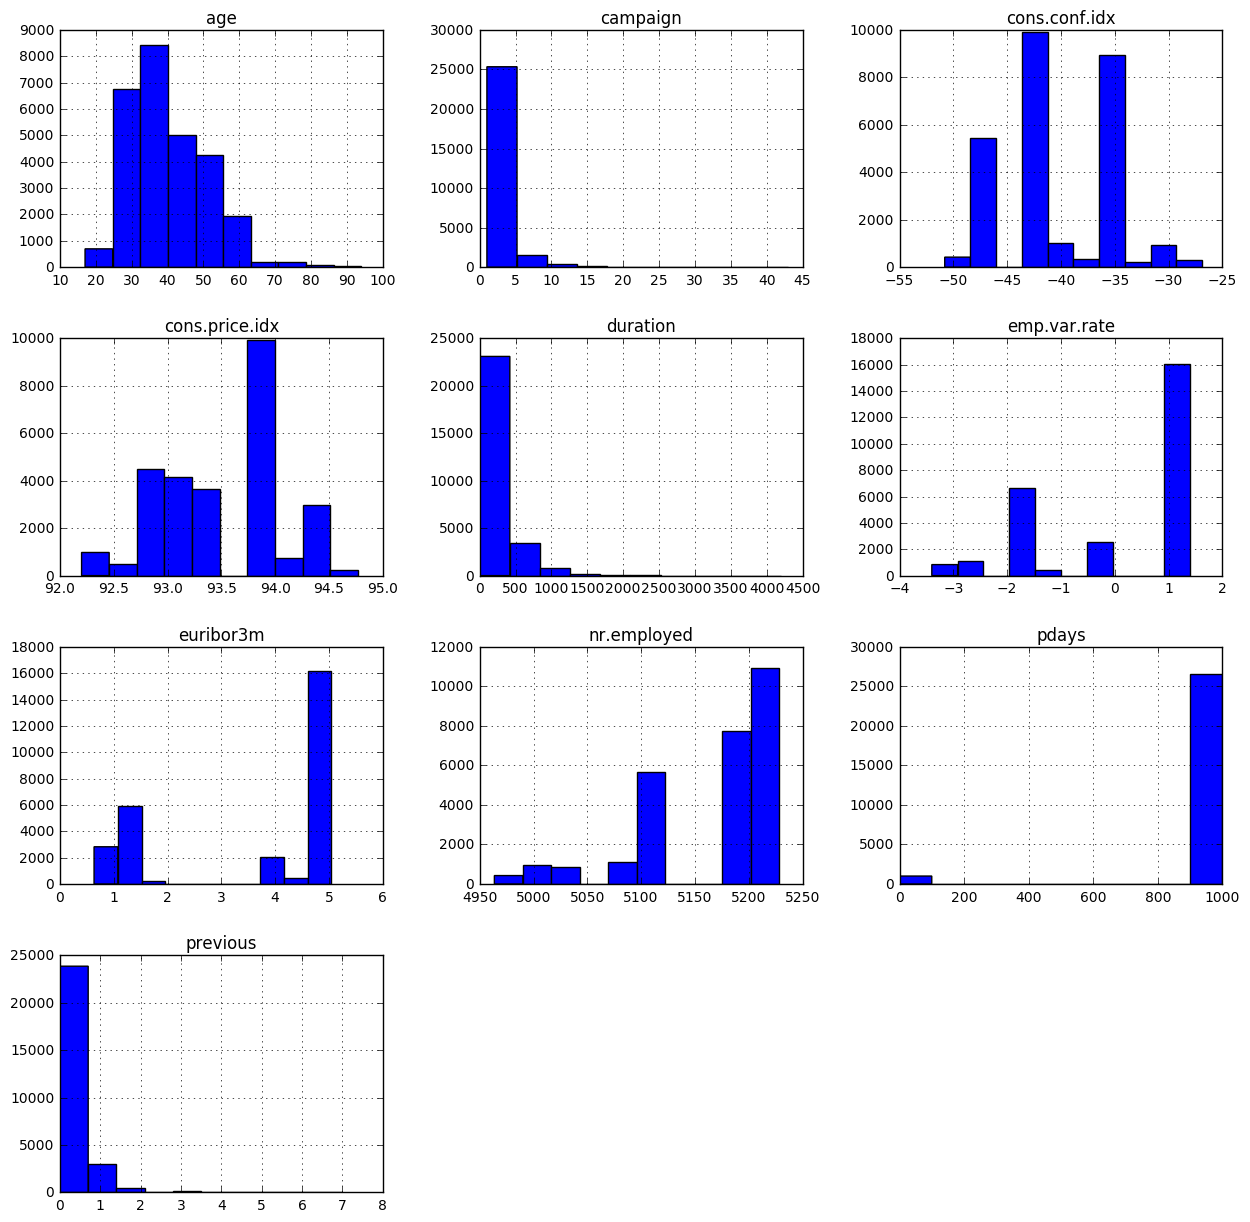

In [5]:
train_data.hist(figsize=(15, 15));

## Обработка категориальных признаков

### Удаление выбросов

In [6]:
print (train_data['marital'][train_data.marital == 'unknown'].value_counts())
print (train_data['job'][train_data.job == 'unknown'].value_counts())
print (train_data.loan[train_data.loan == 'unknown'].value_counts())
print (train_data.education[train_data.education == 'unknown'].value_counts())

unknown    57
Name: marital, dtype: int64
unknown    222
Name: job, dtype: int64
unknown    672
Name: loan, dtype: int64
unknown    1162
Name: education, dtype: int64


In [7]:
obj_to_drop = []
index_drop = list()

obj_to_drop.append(train_data[train_data.marital == 'unknown'].index)
obj_to_drop.append(train_data[train_data.job == 'unknown'].index)
obj_to_drop.append(train_data[train_data.loan == 'unknown'].index)
obj_to_drop.append(train_data[train_data.education == 'unknown'].index)

for i in range(len(obj_to_drop)):
    for j in range(len(obj_to_drop[i])):
        index_drop.append(obj_to_drop[i][j])

In [8]:
train_data = train_data.drop(index_drop).reset_index(drop=True)
train_target = train_target.drop(index_drop).reset_index(drop=True)

In [9]:
def prepare_data(data):
    prepared_data = data.copy()
    prepared_data = prepared_data.drop(['previous', 'default'], axis = 1)
    prepared_data['housing'] = prepared_data.apply(lambda row: 1 if row['housing'] == 'yes' else 0, axis=1)
    prepared_data['loan'] = prepared_data.apply(lambda row: 1 if row['loan'] == 'yes' else 0, axis=1)
    prepared_data['pdays'] = prepared_data.apply(lambda row: 0 if row['pdays'] == 999 else 1, axis=1)
    prepared_data['previous'] = prepared_data.apply(lambda row: 0 if row['previous'] != 999 else 1, axis=1)
    return prepared_data

### Кодирование категориальных признаков

In [11]:
train_data = prepare_data(train_data)

In [12]:
categorical_features = ['job', 'marital', 'education', 'contact', 'month', 'day_of_week', 
                        'poutcome']

In [13]:
from sklearn.feature_extraction import DictVectorizer

dict_vectorizer = DictVectorizer()
features = train_data[categorical_features].T.to_dict().values()
X_category = dict_vectorizer.fit_transform(features).toarray()
X_category = pd.DataFrame(X_category, columns=dict_vectorizer.get_feature_names())

df = pd.concat([X_category,train_data], axis = 1, join='inner')
df = df.drop(categorical_features, axis = 1)

## Undersampling

In [14]:
from imblearn.under_sampling import RandomUnderSampler
sampler = RandomUnderSampler()
df_s, train_target_s = sampler.fit_sample(df, train_target['Answ'].values.ravel())
df_s = pd.DataFrame(df_s, columns = df.columns)
train_target_s = pd.DataFrame(train_target_s, columns = ['Answ'])

C:\Users\Павел\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [15]:
train_target_s['Answ'].value_counts()

1    2850
0    2850
Name: Answ, dtype: int64

In [16]:
train_target_s = train_target_s.Answ.values

# Обработка тестовой выборки

In [18]:
test_data = prepare_data(test_data)

features = test_data[categorical_features].T.to_dict().values()
X_category_t = dict_vectorizer.transform(features).toarray()
X_category_t = pd.DataFrame(X_category_t, columns=dict_vectorizer.get_feature_names())

test_data = pd.concat([X_category_t,test_data], axis = 1, join='inner')
test_data = test_data.drop(categorical_features, axis = 1)

# Разбиение выборки

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
RANDOM_SEED = 664433

#выборка без undersamping
X_train, X_test, y_train, y_test = train_test_split(df, train_target, test_size=0.3, stratify=train_target, 
                                                    random_state=RANDOM_SEED)
#выборка с undersampling
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(df_s, train_target_s, test_size=0.3, stratify=train_target_s, 
                                                    random_state=RANDOM_SEED)

# Feature importances

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [22]:
def weights_print(weights):
    ind = weights.argsort()[::-1]
    print('5 most important feature for the model:')
    for i, index in enumerate(ind[:5]):
        print ('\t{})  {} has {:.4f} weight'.format(i+1, X_train.columns[index], weights[index]))
    return ind[:5]

In [23]:
feat_imp = RandomForestClassifier(random_state=RANDOM_SEED)
feat_imp.fit(X_train, y_train);
feat = weights_print(feat_imp.feature_importances_)

C:\Users\Павел\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


5 most important feature for the model:
	1)  duration has 0.3024 weight
	2)  euribor3m has 0.0911 weight
	3)  age has 0.0776 weight
	4)  poutcome=success has 0.0487 weight
	5)  campaign has 0.0403 weight


# Применение моделей

## 1. RandomForest

In [24]:
parameters = {'criterion':['gini', 'entropy'], 'max_features':[1, 2, 3, 4, 5, 'log2', 'auto'],
         'max_depth':[2, 4, 8, 16, 32, 64], 'class_weight':['balanced', None]}

estimator = RandomForestClassifier(random_state=RANDOM_SEED)
rfc = GridSearchCV(estimator, parameters, scoring='roc_auc', verbose = 1)

rfc.fit(X_train_s, y_train_s);

Fitting 3 folds for each of 168 candidates, totalling 504 fits


[Parallel(n_jobs=1)]: Done 504 out of 504 | elapsed:   30.4s finished


In [25]:
print ('Param: ', rfc.best_params_)
print ('')

rfc_pred = rfc.predict_proba(X_test)
rfc_pred_auc = roc_auc_score(y_test, rfc_pred[:,1])
print ('ROC-AUC score with all features: {}'.format(rfc_pred_auc))

Param:  {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'class_weight': 'balanced'}

ROC-AUC score with all features: 0.9383489592698193


# 2. SVM

## 3. k-NN

In [26]:
from sklearn.neighbors import KNeighborsClassifier

In [27]:
parameters = {'n_neighbors': [30, 50, 70], 'weights': ['uniform', 'distance'], 
              'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'], 
              'leaf_size' : [20, 30, 50], 'p':[1, 2]}

estimator = KNeighborsClassifier()
knn = GridSearchCV(estimator, parameters, scoring='roc_auc', verbose = 1, n_jobs = -1)
knn.fit(X_train_s, y_train_s);

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  1.8min finished


In [28]:
print ('Param: ', knn.best_params_)
print ('')
knn_pred = knn.predict_proba(X_test_s)
knn_pred_auc = roc_auc_score(y_test_s, knn_pred[:,1])

print ('ROC-AUC score with all features: {}'.format(knn_pred_auc))

Param:  {'algorithm': 'ball_tree', 'p': 1, 'weights': 'distance', 'n_neighbors': 70, 'leaf_size': 50}

ROC-AUC score with all features: 0.9416996682739988


## GradBoost

In [29]:
from sklearn.ensemble import GradientBoostingClassifier

parameters = {'loss': ['deviance', 'exponential'], 'max_features':[1, 2, 3, 4, 5, 'log2', 'auto'], 'presort':[True, False],
         'n_estimators':[200, 300], 'min_samples_leaf' : [3]}

estimator = GradientBoostingClassifier(random_state=RANDOM_SEED)
gbc = GridSearchCV(estimator, parameters, scoring='roc_auc', verbose = 1, n_jobs = -1)

gbc.fit(X_train_s, y_train_s);

Fitting 3 folds for each of 56 candidates, totalling 168 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:  1.2min finished


In [30]:
print ('Param: ', gbc.best_params_)
print ('')
gbc_pred = gbc.predict_proba(X_test_s)
gbc_pred_auc = roc_auc_score(y_test_s, gbc_pred[:, 1])

print ('ROC-AUC score with all features: {}'.format(gbc_pred_auc))

Param:  {'max_features': 'auto', 'n_estimators': 300, 'loss': 'exponential', 'presort': False, 'min_samples_leaf': 3}

ROC-AUC score with all features: 0.953540576587668


## 5. VotingClassifier

In [31]:
from sklearn.ensemble import VotingClassifier

In [32]:
eclf = VotingClassifier(estimators=[('rfc', rfc.best_estimator_), 
                                    ('gbc', gbc.best_estimator_), 
                                    ('knn', knn.best_estimator_)], voting='soft')

eclf.fit(X_train_s, y_train_s);

eclf_pred = eclf.predict_proba(X_test_s)
eclf_pred_auc = roc_auc_score(y_test_s, eclf_pred[:,1])

print ('ROC-AUC score with all features: {}'.format(eclf_pred_auc))

ROC-AUC score with all features: 0.9526021681885025


## XGBOOST

In [33]:
import os 
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-5.3.0-posix-seh-rt_v4-rev0\\mingw64\\bin' 
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH'] 

In [34]:
from xgboost import XGBClassifier 

estimator = XGBClassifier(seed=RANDOM_SEED, reg_alpha=0.005, reg_lambda=0.004) 
parameters = {'max_depth': range(2, 10), 'n_estimators': [2, 4, 5, 6, 8, 15, 50, 65, 70, 80], 'objective' : 
['reg:linear', 'binary:logistic', 'binary:logitraw', 'rank:pairwise'], 
'gamma': [0, .2, .3]} 

xgb = GridSearchCV(estimator, parameters, scoring='roc_auc', verbose = 1, n_jobs = -1) 

In [35]:
xgb.fit(X_train, y_train['Answ'].values);

Fitting 3 folds for each of 960 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 23.0min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed: 30.0min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed: 38.0min finished


In [36]:
print ('Param: ', xgb.best_params_) 
print ('') 
xgb_pred = xgb.predict_proba(X_test) 
xgb_pred_auc = roc_auc_score(y_test, xgb_pred[:, 1]) 

print ('ROC-AUC score with all features: {}'.format(xgb_pred_auc))

Param:  {'max_depth': 4, 'n_estimators': 70, 'gamma': 0, 'objective': 'binary:logistic'}

ROC-AUC score with all features: 0.9455040113705444


## Прогноз

In [37]:
xgb_prediction = xgb.predict_proba(test_data)[:,1]
xgb_prediction = pd.DataFrame(xgb_prediction, index = np.arange(0, xgb_prediction.shape[0]), columns=['Prediction'])
xgb_prediction.to_csv('xgb_pred', index_label='Id')